# FEV vs. Alpha Analysis

For each SimCLR layer, this notebook plots **mean FEV** vs. **alpha** (where alpha is the slope of the log–log PCA variance spectrum).

- **Mean FEV** is taken from the regression: SimCLR features (reduced to N PCs) → PC1 Neural data

- For each layer, we select the **best FEV** (i.e., highest across PC counts)

In [1]:
from cortexlib.power_law import PowerLawAlphaEstimator
from cortexlib.utils import file as futils
from cortexlib.utils.logging import Logger
from cortexlib.utils.random import set_global_seed
from cortexlib.utils.plotting import simclr_colours
from adjustText import adjust_text
import matplotlib.pyplot as plt
from tqdm.notebook import tqdm
import pandas as pd

logger = Logger()
set_global_seed()

In [2]:
MOUSE_ID = futils.get_mouse_id()
logger.info(f"This notebook is running for mouse {MOUSE_ID}")

16:49:15 | INFO     | ℹ️ This notebook is running for mouse m03_d4


In [3]:
fev_results = futils.read_json_file_as_dataframe('./prediction.json')
best_fev_per_layer = fev_results.loc[fev_results.groupby("layer")["mean_fev"].idxmax()]

best_fev_per_layer

,layer,n_pcs,test_r2,mean_fev
44,fc,500.0,0.409375,0.432509
1,layer1,10.0,0.383644,0.405533
11,layer2,20.0,0.460465,0.486069
21,layer3,50.0,0.462741,0.488455
34,layer4,400.0,0.431894,0.456116


In [4]:
simclr_data = futils.load_model_features(futils.Model.SIMCLR, MOUSE_ID)
simclr_feats = simclr_data['features']

16:49:15 | INFO     | ℹ️ Loading model features from /Users/callummessiter/workspace/msc-neuro/research-project/analysis/mouse_m03_d4/_model_features/simclr_features_mouse_m03_d4.pt


In [5]:
power_law_alpha_estimator = PowerLawAlphaEstimator()

alpha_results = []

logger.progress(f"Computing α for SimCLR features across layers")
for layer, feats in tqdm(simclr_feats.items(), desc="α for all SimCLR layers"):
    logger.progress(f"SimCLR {layer}")

    feats = feats if feats.dim() <= 2 else feats.view(feats.size(0), -1)
    alpha = power_law_alpha_estimator.compute_alpha_rank(
        feats, # (n_images × n_units)
        kmin=11, 
        kmax=min(500, feats.shape[0], feats.shape[1])
    )

    alpha_results.append({
        'layer': layer,
        'alpha': alpha.alpha,
        'alpha_no_pc1': alpha.alpha_no_pc1,
    })

logger.success(f"Alphas computed")

16:49:15 | INFO     | ⏳ Computing α for SimCLR features across layers...


α for all SimCLR layers:   0%|          | 0/5 [00:00<?, ?it/s]

16:49:15 | INFO     | ⏳ SimCLR layer1...
16:49:27 | INFO     | ⏳ SimCLR layer2...
16:49:32 | INFO     | ⏳ SimCLR layer3...
16:49:35 | INFO     | ⏳ SimCLR layer4...
16:49:37 | INFO     | ⏳ SimCLR fc...
16:49:37 | SUCCESS  | ✅ Alphas computed!


In [6]:
futils.write_json_file(alpha_results, './dimensionality.json')

In [7]:
alpha_results_df = pd.DataFrame(alpha_results)
alpha_results_df

,layer,alpha,alpha_no_pc1
0,layer1,0.514907,0.514907
1,layer2,0.741496,0.741496
2,layer3,0.958203,0.958203
3,layer4,1.130684,1.130684
4,fc,1.620274,1.620274


In [8]:
merged_results = pd.merge(best_fev_per_layer, alpha_results_df, on='layer')
merged_results

,layer,n_pcs,test_r2,mean_fev,alpha,alpha_no_pc1
0,fc,500.0,0.409375,0.432509,1.620274,1.620274
1,layer1,10.0,0.383644,0.405533,0.514907,0.514907
2,layer2,20.0,0.460465,0.486069,0.741496,0.741496
3,layer3,50.0,0.462741,0.488455,0.958203,0.958203
4,layer4,400.0,0.431894,0.456116,1.130684,1.130684


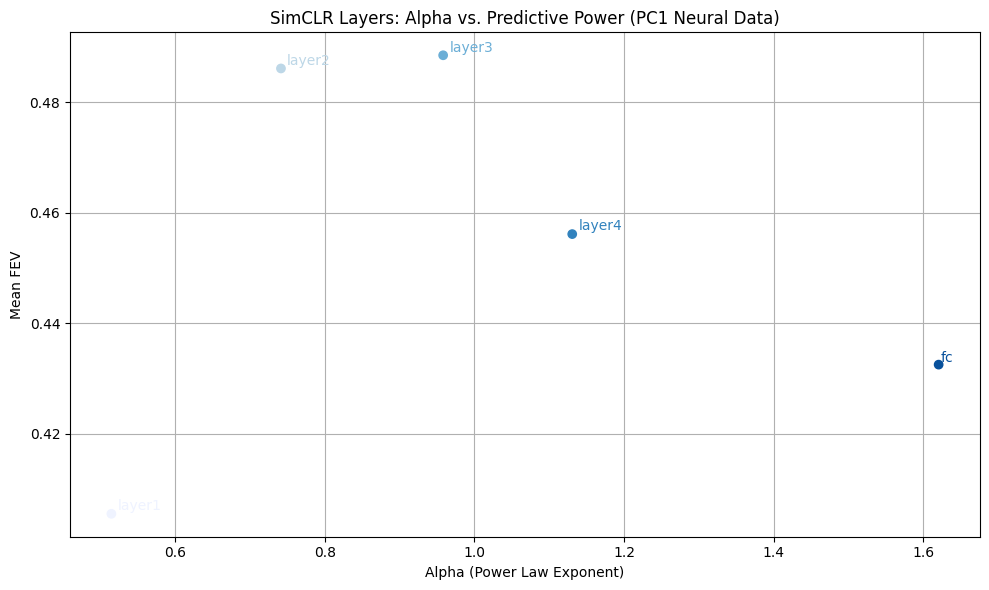

In [9]:
colours = merged_results['layer'].map(simclr_colours)

plt.figure(figsize=(10, 6))
plt.scatter(merged_results['alpha'], merged_results['mean_fev'], c=colours)

texts = []
for _, row in merged_results.iterrows():
    texts.append(
        plt.text(row['alpha'], row['mean_fev'], row['layer'],
                 color=simclr_colours[row['layer']], fontsize=10)
    )

adjust_text(texts, arrowprops=dict(arrowstyle='-', color='gray'))

plt.xlabel('Alpha (Power Law Exponent)')
plt.ylabel('Mean FEV')
plt.title('SimCLR Layers: Alpha vs. Predictive Power (PC1 Neural Data)')
plt.grid(True)
plt.tight_layout()
plt.show()